## 0. Import libraries


In [ ]:
import pandas as pd
import os
import sys
from pathlib import Path
import time
from openai import OpenAI
import random
from docx import Document
from analysis_util import *
from config import WHOLE_SETS_PATH
from model_config import model_path, get_tokenizer, model_init, get_device, MAX_LENGTH

## 1. Plot the results

In [8]:
# Please change the file path to the results you want to plot
results_file = '../results/demo_results.csv'

# Prepare the df for plotting
df = pd.read_csv(results_file)
df['difference'] = df['Test F1'] - df['Pred F1']
df['Pred End'] = pd.to_datetime(df['Pred End'])
df['year_month'] = df['Pred End'].dt.strftime('%Y-%m')

In [9]:
# Define the significant event list
event_dates = [
        (datetime(2022, 3, 6), '- Inter-Korean projects destroyed’'),
        (datetime(2022, 3, 24), '- Resumed testing liquid-fuel ICBM'),
        (datetime(2022, 4, 25), '- Nuclear vision announced'),
        (datetime(2022, 5, 12), '- COVID emergency'),
        (datetime(2022, 8, 10), '- COVID victory declared'),
        (datetime(2022, 11, 18), '- Hwasong-17 launch'),
        (datetime(2023, 4, 13), '- Hwasong-18 launch'),
        (datetime(2023, 9, 12), '- Kim visits Russia'),
        (datetime(2023, 11, 21), '- Malligyong-1 spy satellite launch'),
        (datetime(2023, 12, 31), '- Reunification goal abandoned'),
        (datetime(2024, 2, 8), '- Economic cooperation law abolished'),
        (datetime(2024, 3, 15), '- Signal of Kim\'s daughter as successor')
    ]

Saved figure to ../results/figures/f1_scores_over_time.png


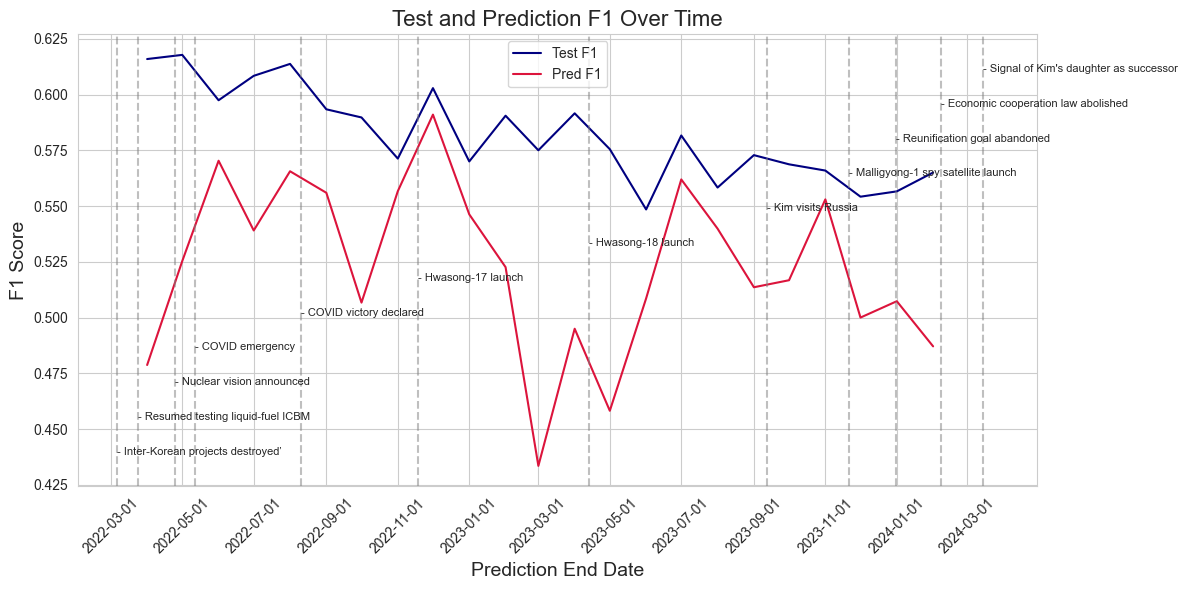

Saved figure to ../results/figures/f1_diff_over_time.png


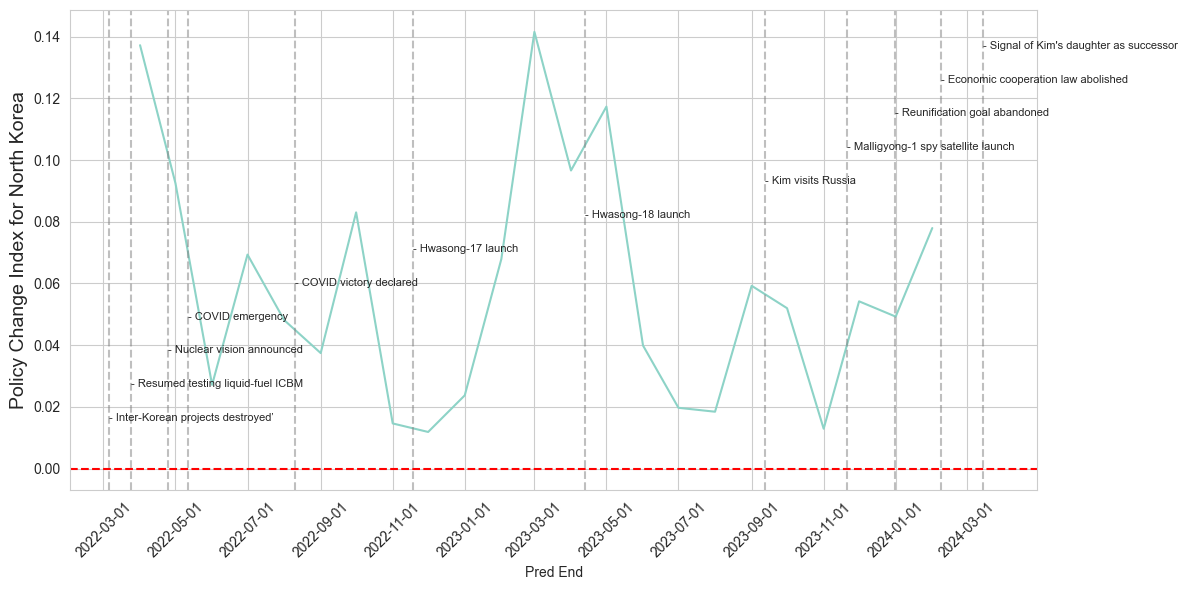

In [10]:
# Plot the results and save the figure to ./results/figures
plot_results(df, event_dates)

## 2. LLM analysis (for individual episodes)

### 2.1 Load data and best model

In [2]:
# List the start dates of the episodes to be evaluated, choose from your model directory
start_date_list =[
    "2018-01-01",
    "2018-07-01",
    "2018-12-01",
]

# List the paths of the best models for the episodes
model_path_list = [f'{model_path}/{d}/best_model' for d in start_date_list]

- Select a start date

In [3]:
d = start_date_list[1]
model_path = model_path_list[1]
train_start, train_end, pred_start, pred_end, train_start_YM, train_end_YM, pred_start_YM, pred_end_YM = generate_dates(d)
print(f"train_start: {train_start}\ntrain_end: {train_end}\npred_start: {pred_start}\npred_end: {pred_end}")

train_start: 2018-07-01 00:00:00
train_end: 2022-07-01 00:00:00
pred_start: 2022-07-01 00:00:00
pred_end: 2022-10-01 00:00:00


In [4]:
# Prepare test set from the prediction window
df_path = "../data/raw/demoset.csv" # Change to the path of your raw dataset
df = pd.read_csv(df_path)
pred_df = load_and_split_data(df, d)[1][['publication_date', 'text', 'front_page']]
pred_df.shape

(3220, 3)

In [5]:
pred_df.head()

,publication_date,text,front_page
0,2022-07-01,몇해사이에 축산물생산을 획기적으로 늘인 비결 《집짐승을 대대적으로 길러 고기를 비롯...,0
1,2022-07-01,대중적기술혁신운동을 활발히 벌리며 지난 기간 공장에서는 연소모형에 의한 주조공정을 ...,0
2,2022-07-01,<확대되고있는 신형코로나비루스감염증피해> 유럽과 아메리카지역에서 북아메리카에서 １억...,0
3,2022-07-01,<확대되고있는 신형코로나비루스감염증피해> 세계적으로 ５억 ５ １５２만 ８ ６００여명...,0
4,2022-07-01,"《축하합니다!》 꽃다발을 안겨주는 공장기동예술선동대원들의 얼굴에도, 꽃다발을 받아안...",0


In [13]:
# Prepare the test set from the training window
try:
    dataset_path = str(WHOLE_SETS_PATH)
    train_df = test_set_to_dataframe(dataset_path)
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    print("\nDetailed error traceback:")
    print(traceback.format_exc())

train_df = extract_data_by_date_range(train_df, train_start, train_end)
train_df.tail()

Loading dataset...
Dataset loaded successfully.
Converting test set to pandas DataFrame...
Conversion completed.


,publication_date,text,front_page
10020,2022-06-24,조선로동당 중앙군사위원회 제８기 제３차확대회의에 관한 보도 확대회의에는 조선로동당 ...,1
10021,2022-06-24,<당정책관철을 위한 도들의 경쟁열의가 더욱 고조된다-육아정책을 높이 받들고> 사덕등...,0
10022,2022-06-24,세계각국의 보건위기상황에서 찾게 되는 교훈 세계의 많은 나라들에서 방역위기가 완화될...,0
10023,2022-06-24,확대되고있는 신형코로나비루스감염증피해 아시아의 대류행병전파상황\n\n아시아에서 ２２...,0
10024,2022-06-24,<방역대전에서 누구나 알아야 할 상식> 기관지감염증상이 나타날 때 어떻게 할것인가 ...,0


In [14]:
# Prepare the best model
model = model_init(model_path)
tokenizer = get_tokenizer()
device = get_device()
model.eval()

System platform: darwin
Checking for Apple MPS...
MPS is available.
System platform: darwin
Checking for Apple MPS...
MPS is available.


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

### 2.2 Run the model

In [15]:
# Evaluate the model on both training and prediction sets
try:
    train_df = classify_texts(train_df, model, tokenizer, device, label_column='front_page', max_length=256, threshold=0.5, invert_predictions=True)

    pred_df = classify_texts(pred_df, model, tokenizer, device, label_column='front_page', max_length=256, threshold=0.5, invert_predictions=True)

    for df_name, df in [("Training", train_df), ("Prediction", pred_df)]:
        print(f"\n{df_name} Set Results:")
        print(df['result'].value_counts())
        print(df['prediction_type'].value_counts())
        
        metrics = calculate_metrics(df, label_column='front_page')
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
# Save the results to csv if needed
    # test_df.to_csv('test_results.csv', index=False) 
    # pred_df.to_csv('pred_results.csv', index=False)

except Exception as e:
    print(f"An error occurred: {str(e)}")

100%|██████████| 278/278 [01:30<00:00,  3.06it/s]


Shape of 'result' column: (8896,)
Distribution of 'result' column: result
0    0.847684
1    0.152316
Name: proportion, dtype: float64
Shape of 'front_page' column: (8896,)
Distribution of 'front_page' column: front_page
0    0.895459
1    0.104541
Name: proportion, dtype: float64


100%|██████████| 101/101 [00:32<00:00,  3.08it/s]

Shape of 'result' column: (3220,)
Distribution of 'result' column: result
0    0.87764
1    0.12236
Name: proportion, dtype: float64
Shape of 'front_page' column: (3220,)
Distribution of 'front_page' column: front_page
0    0.906522
1    0.093478
Name: proportion, dtype: float64

Training Set Results:
result
0    7541
1    1355
Name: count, dtype: int64
prediction_type
TN    7269
FP     697
TP     658
FN     272
Name: count, dtype: int64
Accuracy: 0.8911
Precision: 0.4856
Recall: 0.7075
F1 Score: 0.5759

Prediction Set Results:
result
0    2826
1     394
Name: count, dtype: int64
prediction_type
TN    2696
FP     223
TP     171
FN     130
Name: count, dtype: int64
Accuracy: 0.8904
Precision: 0.4340
Recall: 0.5681
F1 Score: 0.4921


In [24]:
pred_df.sample(5)

,publication_date,text,front_page,result,prediction_type
858,2022-07-26,김덕훈 내각총리 황해남도의 농업부문 사업을 현지료해 당면한 영농공정수행에서 나타나고...,0,1,FP
1563,2022-08-16,열파현상 지속 지중해연안지역에 영향을 미친 열파는 현재 프랑스의 서남부지역으로 번져...,0,0,TN
2687,2022-09-17,재해성기상현상에 계속 철저히 대처하자 특파기자,0,0,TN
2603,2022-09-15,생산에서 제기되는 과학기술적문제들을 적극 풀어나간다. 특파기자,0,0,TN
3175,2022-09-29,이스라엘의 불법무도한 만행 규탄 성명은 이스라엘의 행위는 국제법에 대한 란폭한 위반...,0,0,TN


In [26]:
def sample_for_FOR(train_df, pred_df, tn_fn_ratio=1, random_seed=23):

    if random_seed is not None:
        np.random.seed(random_seed)
        
    pred_fn = pred_df[pred_df['prediction_type'] == 'FN']
    pred_tn = pred_df[pred_df['prediction_type'] == 'TN']
    
    pred_tn_sampled = pred_tn.sample(n=min(len(pred_tn), len(pred_fn) * tn_fn_ratio), replace=False, random_state=random_seed)
    pred_sample = pd.concat([pred_fn, pred_tn_sampled])
    
    train_fn = train_df[train_df['prediction_type'] == 'FN']
    train_tn = train_df[train_df['prediction_type'] == 'TN']
    
    train_fn_sampled = train_fn.sample(n=min(len(train_fn), len(pred_fn)), replace=False, random_state=random_seed)
    train_tn_sampled = train_tn.sample(n=min(len(train_tn), len(train_fn_sampled) * tn_fn_ratio), replace=False, random_state=random_seed)
    train_sample = pd.concat([train_fn_sampled, train_tn_sampled])

    print("Train sample count：")
    print(train_sample['prediction_type'].value_counts())
    print("\nPred sample count：")
    print(pred_sample['prediction_type'].value_counts())
    
    return train_sample, pred_sample
# Sample the data for comparing False Omission Rate (FOR)
train_sample, pred_sample = sample_for_FOR(train_df, pred_df)

Train sample count：
prediction_type
FN    130
TN    130
Name: count, dtype: int64

Pred sample count：
prediction_type
FN    130
TN    130
Name: count, dtype: int64


In [31]:
# Save the sampled data to csv
train_sample.to_csv('train_sample.csv', index=False)
pred_sample.to_csv('pred_sample.csv', index=False)

**Note:** Processing text datasets with LLMs can be time-consuming. To save time during iterative experiments and prevent data loss from unexpected interruptions, it's advisable to save intermediate results to disk. However, feel free to delete these tentatively generated files once you've obtained the final analysis results.

### 2.3 Use LLM to process the sampled data

In [30]:
"""
Set up the OpenRouter API and models in the analysis_util.py file

### Candidate models as of Aug 2024 ###
or_model1 = "meta-llama/llama-3.1-8b-instruct"
or_model2 = "meta-llama/llama-3.1-70b-instruct"
or_model3 = "openai/gpt-4o-mini-2024-07-18"
or_model4 = "openai/gpt-4o-2024-08-06"
or_model5 = "anthropic/claude-3.5-sonnet"
or_model6 = "meta-llama/llama-3.1-405b-instruct"
or_model7 = "google/gemini-pro-1.5-exp"
or_model8 = "deepseek/deepseek-chat"

### Models used for this analysis ###
translation_model = or_model3
backup_model = or_model4
analysis_model = or_model5
"""

**Note:** Please find details on the LLM prompts for translation and analysis in the `analysis_util.py` file.

In [34]:
translate_csv('pred_sample.csv', 'pred_sample_tran.csv')
translate_csv('train_sample.csv', 'train_sample_tran.csv')

Total rows in input file: 260
Resuming from existing output file: pred_sample_tran.csv
Translations completed: 260


Translating: 100%|██████████| 260/260 [00:00<?, ?row/s]


Translation process completed.
Final save completed.
Total rows in input file: 260
Resuming from existing output file: train_sample_tran.csv
Translations completed: 20


Translating:  15%|█▌        | 40/260 [01:32<15:53,  4.33s/row]

Translated and saved up to row 40


Translating:  23%|██▎       | 60/260 [02:46<11:00,  3.30s/row]

Translated and saved up to row 60


Translating:  31%|███       | 80/260 [04:14<12:12,  4.07s/row]

Translated and saved up to row 80


Translating:  38%|███▊      | 100/260 [05:40<14:04,  5.28s/row]

Translated and saved up to row 100


Translating:  46%|████▌     | 120/260 [07:14<08:31,  3.65s/row]

Translated and saved up to row 120


Translating:  54%|█████▍    | 140/260 [08:23<04:24,  2.21s/row]

Translated and saved up to row 140


Translating:  62%|██████▏   | 160/260 [09:58<10:02,  6.03s/row]

Translated and saved up to row 160


Translating:  69%|██████▉   | 180/260 [11:26<06:09,  4.61s/row]

Translated and saved up to row 180


Translating:  77%|███████▋  | 200/260 [12:46<04:10,  4.18s/row]

Translated and saved up to row 200


Translating:  85%|████████▍ | 220/260 [13:35<01:35,  2.38s/row]

Translated and saved up to row 220


Translating:  92%|█████████▏| 240/260 [14:55<01:31,  4.56s/row]

Translated and saved up to row 240


Translating: 100%|██████████| 260/260 [16:05<00:00,  4.02s/row]

Translated and saved up to row 260
Translation process completed.
Final save completed.


In [35]:
train_sample_tran = pd.read_csv('train_sample_tran.csv')
pred_sample_tran = pd.read_csv('pred_sample_tran.csv')
train_sample_tran.head()
pred_sample_tran.head()

,publication_date,text,front_page,result,prediction_type,Translation_EN-US
0,2022-07-01,위대한 년대의 불멸할 자욱을 길이 전하는 고귀한 재보 조국해방전쟁승리기념관을 세계적...,1,0,FN,**Translation:**\n\nIn order to splendidly est...
1,2022-07-03,최악의 역경을 강용히 뚫고나아가는 우리 인민의 억센 기상 《사회주의경제건설은 오늘 ...,1,0,FN,**Our People’s Indomitable Spirit Overcoming t...
2,2022-07-03,생산장성의 담보를 마련해가고있다. 리동명,1,0,FN,"""Securing the guarantee for production growth...."
3,2022-07-10,과학기술보급사업을 활발히 벌려나가고있다. 특파기자,1,0,FN,The dissemination of scientific and technologi...
4,2022-07-12,당정책은 인민의 요구와 리익실현의 절대적인 지침이며 위력한 무기이다 경애하는 김정은...,1,0,FN,The Party policy is an absolute guideline for ...


In [41]:
train_sample_proc = process_df(train_sample_tran)
pred_sample_proc = process_df(pred_sample_tran)
train_sample_proc.head()
pred_sample_proc.head()
# Save the processed data to csv
train_sample_proc.to_csv('train_sample_proc.csv', index=False)
pred_sample_proc.to_csv('pred_sample_proc.csv', index=False)

Processing entries:  17%|█▋        | 45/260 [02:25<11:02,  3.08s/it]

Attempt 1: Error occurred: Expecting value: line 5 column 1 (char 22). Retrying in 5 seconds...


Processing entries: 100%|██████████| 260/260 [14:18<00:00,  3.30s/it]


In [43]:
pred_sample_proc['Policy Area'].value_counts()

Policy Area
Social Policy and Ideology         78
Agriculture and Food Security      63
Economic and Industrial Policy     40
Public Health and Safety           38
Infrastructure and Public Works    20
Defense and National Security       6
Education and Human Capital         6
Foreign Relations and Diplomacy     4
Science and Technology              3
Miscellaneous                       1
Labor and Employment                1
Name: count, dtype: int64

In [44]:
train_sample_proc['Policy Area'].value_counts()

Policy Area
Social Policy and Ideology         80
Agriculture and Food Security      52
Economic and Industrial Policy     34
Public Health and Safety           34
Infrastructure and Public Works    18
Foreign Relations and Diplomacy    15
Science and Technology             11
Education and Human Capital        10
Defense and National Security       4
Miscellaneous                       1
Labor and Employment                1
Name: count, dtype: int64

### 2.5 Calculate False Omission Rate (FOR) to identify policy areas that need focused analysis

In [76]:
"""
Please customize the policy areas here and in the `analysis_util.py` file as needed.
Policy areas defined in this analysis include the following:
"""
ALL_POLICY_AREAS = [
    'Economic and Industrial Policy', 
    'Agriculture and Food Security',
    'Infrastructure and Public Works',
    'Public Health and Safety', 
    'Defense and National Security', 
    'Social Policy and Ideology',
    'Labor and Employment', 
    'Education and Human Capital', 
    'Foreign Relations and Diplomacy', 
    'Science and Technology', 
    'Miscellaneous'
]


In [77]:
train_for = calculate_false_omission_rate(train_sample_proc)
pred_for = calculate_false_omission_rate(pred_sample_proc)

print("Training Sample False Omission Rates:")
print(train_for)
print("\nPrediction Sample False Omission Rates:")
print(pred_for)

Training Sample False Omission Rates:
Policy Area
Economic and Industrial Policy     0.735294
Agriculture and Food Security      0.500000
Infrastructure and Public Works    0.833333
Public Health and Safety           0.205882
Defense and National Security      0.750000
Social Policy and Ideology         0.525000
Labor and Employment               0.000000
Education and Human Capital        0.500000
Foreign Relations and Diplomacy    0.066667
Science and Technology             0.454545
Miscellaneous                      1.000000
Name: prediction_type, dtype: float64

Prediction Sample False Omission Rates:
Policy Area
Economic and Industrial Policy     0.775000
Agriculture and Food Security      0.587302
Infrastructure and Public Works    0.450000
Public Health and Safety           0.368421
Defense and National Security      0.333333
Social Policy and Ideology         0.435897
Labor and Employment               0.000000
Education and Human Capital        0.333333
Foreign Relations and D

In [111]:
train_counts = generate_counts(train_sample_proc, ALL_POLICY_AREAS)
pred_counts = generate_counts(pred_sample_proc, ALL_POLICY_AREAS)

print("Training Sample Counts:")

for policy, (fn, total) in zip(ALL_POLICY_AREAS, train_counts):
    print(f"{policy}: FN = {fn}, Total = {total}")
print("\n")
for policy, (fn, total) in zip(ALL_POLICY_AREAS, pred_counts):
    print(f"{policy}: FN = {fn}, Total = {total}")

Training Sample Counts:
Economic and Industrial Policy: FN = 25, Total = 34
Agriculture and Food Security: FN = 26, Total = 52
Infrastructure and Public Works: FN = 15, Total = 18
Public Health and Safety: FN = 7, Total = 34
Defense and National Security: FN = 3, Total = 4
Social Policy and Ideology: FN = 42, Total = 80
Labor and Employment: FN = 0, Total = 1
Education and Human Capital: FN = 5, Total = 10
Foreign Relations and Diplomacy: FN = 1, Total = 15
Science and Technology: FN = 5, Total = 11
Miscellaneous: FN = 1, Total = 1


Economic and Industrial Policy: FN = 31, Total = 40
Agriculture and Food Security: FN = 37, Total = 63
Infrastructure and Public Works: FN = 9, Total = 20
Public Health and Safety: FN = 14, Total = 38
Defense and National Security: FN = 2, Total = 6
Social Policy and Ideology: FN = 34, Total = 78
Labor and Employment: FN = 0, Total = 1
Education and Human Capital: FN = 2, Total = 6
Foreign Relations and Diplomacy: FN = 0, Total = 4
Science and Technology: 

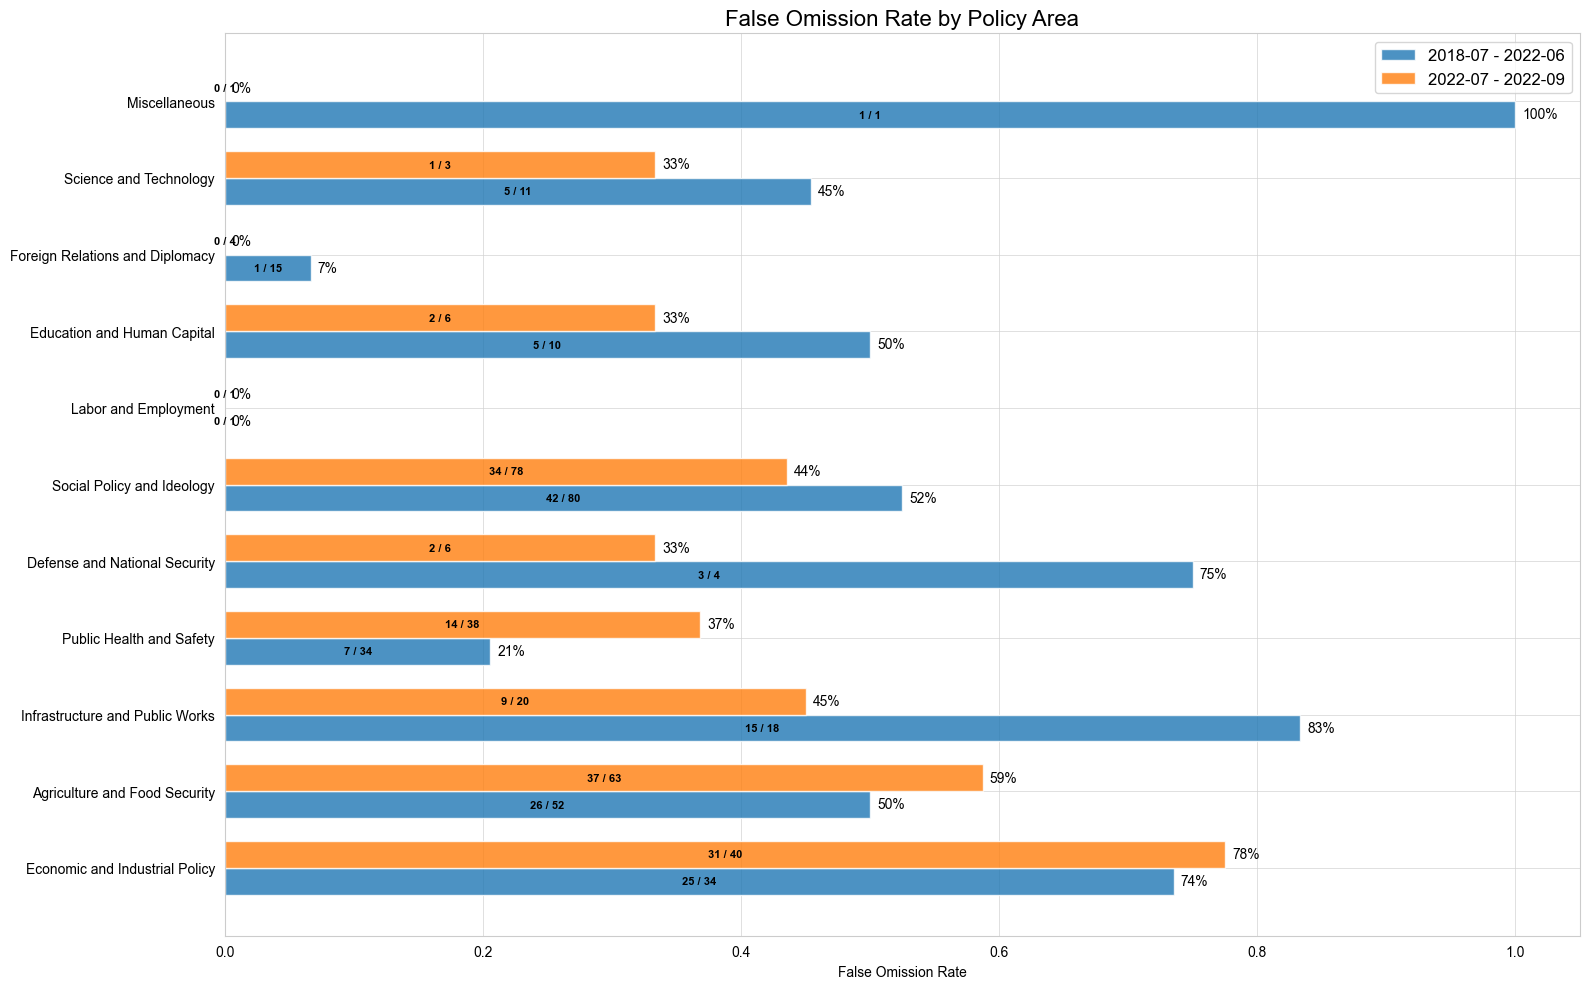

In [131]:
train_end_YM_new = get_previous_month(train_end_YM)
pred_end_YM_new = get_previous_month(pred_end_YM)
train_date_range = f"{train_start_YM} - {train_end_YM_new}" 
pred_date_range = f"{pred_start_YM} - {pred_end_YM_new}"  
pred_start_date = pred_start_YM      

plot_false_omission_rates(train_for, pred_for, train_counts, pred_counts,train_date_range, pred_date_range,pred_start_date)

### 2.6 Focused analysis on policy areas with significant changes in False Omission Rate (FOR)

In [97]:
# Find the policy areas that have significant changes in False Omission Rate
for_change = pred_for - train_for
print("\nChange in False Omission Rate (Prediction - Training):")
print(for_change.sort_values(ascending=False))

print("\nSample counts for each Policy Area:")
train_counts = train_sample_proc['Policy Area'].value_counts().reindex(ALL_POLICY_AREAS, fill_value=0)
pred_counts = pred_sample_proc['Policy Area'].value_counts().reindex(ALL_POLICY_AREAS, fill_value=0)
all_counts = pd.DataFrame({'Train': train_counts, 'Prediction': pred_counts}).fillna(0).astype(int)
print(all_counts)


results = filter_policy_areas(for_change, all_counts)
focused_policies = [area[0] for area in results['significant_change'] + results['potential_change']]
print(f'The focused policy areas for analysis include: {focused_policies}')


Change in False Omission Rate (Prediction - Training):
Policy Area
Public Health and Safety           0.162539
Agriculture and Food Security      0.087302
Economic and Industrial Policy     0.039706
Labor and Employment               0.000000
Foreign Relations and Diplomacy   -0.066667
Social Policy and Ideology        -0.089103
Science and Technology            -0.121212
Education and Human Capital       -0.166667
Infrastructure and Public Works   -0.383333
Defense and National Security     -0.416667
Miscellaneous                     -1.000000
Name: prediction_type, dtype: float64

Sample counts for each Policy Area:
                                 Train  Prediction
Policy Area                                       
Economic and Industrial Policy      34          40
Agriculture and Food Security       52          63
Infrastructure and Public Works     18          20
Public Health and Safety            34          38
Defense and National Security        4           6
Social Policy an

In [98]:
analysis_result = analyze_policy_changes(train_sample_proc, pred_sample_proc, focused_policies)
print(analysis_result)

Based on the analysis of the article summaries and tags from both periods, here's a comprehensive breakdown of the main themes, changes, and potential policy shifts observed:

1. Emerging or increasing themes in Period 2:

a) Natural Disaster Preparedness:
There's a significant increase in focus on natural disaster preparedness, particularly for typhoons, heavy rains, and flooding. For example:
- "North Korean authorities calling for strengthened measures against heavy rain and flooding"
- "Kim Jong Un presided over the National Disaster Prevention Work Review Meeting"
- Multiple summaries detailing typhoon preparation efforts and weather forecasts

This suggests a heightened awareness of climate-related risks and a shift towards proactive disaster management.

b) Monkeypox Concerns:
Period 2 introduces mentions of monkeypox, indicating North Korea's awareness of emerging global health threats:
- "North Korea emphasizes the importance of rapid testing for suspected monkeypox cases"

c)

In [100]:
# Create a Word document to save the analysis results
doc = Document()
doc.add_heading('Policy Analysis Report', 0)

doc.add_heading('Policy areas requiring focused analysis:', level=1)
for category, areas in results.items():
    doc.add_heading(f"{category.capitalize()}:", level=2)
    for area in areas:
        doc.add_paragraph(f"{area[0]}: FOR change = {area[1]:.4f}, Total sample = {area[2]}")

doc.add_heading('Detailed Analysis', level=1)
doc.add_paragraph(analysis_result)

doc.save(f'../results/analysis_results/{pred_start_date}_FOR_analysis.docx')